In [1]:
import tensorflow as tf

# 1. List all physical GPU devices.
gpus = tf.config.experimental.list_physical_devices('GPU')

if len(gpus) > 3: 
    # 2. Use only GPU 1, GPU 2, and GPU 3.
    tf.config.experimental.set_visible_devices([gpus[0],gpus[1], gpus[2], gpus[3]], 'GPU')

    # 3. Set memory growth for GPU 1, GPU 2, and GPU 3.
    for gpu in [gpus[0],gpus[1], gpus[2], gpus[3]]:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("Not enough GPUs.")

strategy = tf.distribute.MirroredStrategy()  
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


In [148]:
import cv2
import math                 
import numpy as np           
import scipy.io as sio       
import matplotlib as plt     
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import netcdf as nc      
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import custom_object_scope
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
import datetime
from tensorflow.keras.models import save_model
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LambdaCallback


Functions

In [115]:
# Pixel based metrics for binary semantic segmentation

smooth = 1

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))  # Cast y_true to float32
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))  # Cast y_pred to float32
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

binary_iou = tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)

def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_score_Loss(y_true, y_pred):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)   
    return 1. - score

def F1_score(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
def save_model_results(model, X_train, y_train, X_test, y_test, train_folder, test_folder):
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Saving predictions and original data for train set
    predictions_train = model.predict(X_train, batch_size=1)
    for i, pred in enumerate(predictions_train):
        pred_image = (pred * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(train_folder, f"Predicted_train_img_{i}.png"), pred_image)
        mask_image = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(train_folder, f"Train_mask_img_{i}.png"), mask_image)
        original_image = (X_train[i] * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(train_folder, f"Train_img_{i}.png"), original_image)

    # Saving predictions and original data for test set
    predictions_test = model.predict(X_test, batch_size=1)
    for i, pred in enumerate(predictions_test):
        pred_image = (pred * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(test_folder, f"Predicted_test_img_{i}.png"), pred_image)
        mask_image = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(test_folder, f"Mask_test_img_{i}.png"), mask_image)
        original_image = (X_test[i] * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(test_folder, f"Image_test_img_{i}.png"), original_image)


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history_list, num_folds):

    for fold in range(num_folds):
        train_loss = history_list[fold]['loss']
        val_loss = history_list[fold]['val_loss']
        train_F1_score = history_list[fold]['dice_coef']
        val_F1_score = history_list[fold]['val_dice_coef']
        
        plt.figure(figsize=(12, 5))

        # Plot training and validation loss
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label='Train Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.title(f'Training and Validation Loss (Fold {fold + 1})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot training and validation F1 score
        plt.subplot(1, 2, 2)
        plt.plot(train_F1_score, label='Train dice')
        plt.plot(val_F1_score, label='Validation dice')
        plt.title(f'Training and Validation dice (Fold {fold + 1})')
        plt.xlabel('Epoch')
        plt.ylabel('Dice coef')
        plt.legend()

        plt.show()


In [ ]:
def read_files(input_dir,target_dir):

    input_img_paths = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".png")
        ]
    )
    target_img_paths = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".png") and not fname.startswith(".")
        ]
    )

    print("Number of samples:", len(input_img_paths))
    print("Number of samples:", len(target_img_paths))
    for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
        print(input_path, "|", target_path)
    return input_img_paths, target_img_paths

In [ ]:
import numpy as np
import cv2
from skimage.transform import resize

def create_image_mask_new(input_img_paths, target_img_paths, mask_IMAGE_DIMS, image_IMAGE_DIMS):
    images = []
    masks = []
   
    for (ii, (im_path, mask_path)) in enumerate(zip(input_img_paths, target_img_paths)):
        # Process the image
        image = cv2.imread(im_path)
        image = resize(image, image_IMAGE_DIMS, mode='constant', preserve_range=True)
        image = image / 255
        images.append(image)

        # Process the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = resize(mask, mask_IMAGE_DIMS, mode='constant', preserve_range=True)
        mask_binary = (mask>= 10).astype(np.uint8)   # Thresholding
        masks.append(mask_binary)

    images = np.array(images)
    masks = np.array(masks)
    return images, masks

In [162]:
# data augmentation
from tqdm import tqdm
from glob import glob
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
def augment_data(images, masks, save_path, augment=True):
    H = 1024
    W = 1408

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        # Extracting the name and extension of the image and the mask. 
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        # Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

       # Augmentation """
        if augment == True:


            aug = GridDistortion(p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']
         

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            save_images = [x,x3,x4]
            save_masks =  [y, y3,  y4]

        else:
            save_images = [x]
            save_masks = [y]

       # Saving the image and mask. 
        idx = 0
        for i, m in zip(save_images, save_masks):
            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "train_image_flip_noise", tmp_img_name)
            mask_path = os.path.join(save_path, "train_mask_flip_noise", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1
def load_data():
    input_dir = "./Surface/train/image/"   
    target_dir = "./Surface/train/mask/"

    images = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".png")
        ]
    )
    masks = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".png") and not fname.startswith(".")
        ]
    )
    return images, masks
    
def create_dir(path):

    if not os.path.exists(path):
        print("not")
        os.makedirs(path)   
images, masks = load_data()
print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")
create_dir("./Surface/train/train_image_flip_noise/")
create_dir("./Surface/train/train_mask_flip_noise/")
save_path="./Surface/train_1/"
augment_data(images, masks, save_path, augment=True)

Original Images: 340 - Original Masks: 340


  0%|          | 0/340 [00:00<?, ?it/s]

100%|██████████| 340/340 [00:24<00:00, 13.69it/s]


In [160]:
# Divide data into train and test, then augment each set separately

import os
import random
from shutil import copyfile
from sklearn.model_selection import train_test_split

# Set paths
image_dir = "./LAYERS-images_one_channel"
mask_dir = "./Surface_bedrock_3"
train_image_dir = "./Surface/train/image"
train_mask_dir = "./Surface/train/mask"
test_image_dir = "./Surface/test/image"
test_mask_dir = "./Surface/test/mask"

# Create directories
for directory in [train_image_dir, train_mask_dir, test_image_dir, test_mask_dir]:
    os.makedirs(directory, exist_ok=True)

# Set random seed
random.seed(42)
def get_sorted_file_list(directory, extension):
    return sorted(
        [
            fname for fname in os.listdir(directory)
            if fname.endswith(extension) and not fname.startswith(".")
        ]
    )

# Sort files in both directories
image_filenames = get_sorted_file_list(image_dir, ".png")
mask_filenames = get_sorted_file_list(mask_dir, ".png") 

# Check if the sorted lists have one-to-one correspondence
if len(image_filenames) != len(mask_filenames) or any(i.split('.')[0] != m.split('.')[0] for i, m in zip(image_filenames, mask_filenames)):
    raise ValueError("Mismatch between image and mask files")

# Split data into train and test sets
image_train, image_test = train_test_split(image_filenames, test_size=0.2, random_state=0)
mask_train, mask_test = train_test_split(mask_filenames, test_size=0.2, random_state=0)

# Function to copy files
def copy_files(file_list, source_dir, target_dir):
    for filename in file_list:
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_dir, filename)
        copyfile(source_path, target_path)

# Copy train and test images and masks
copy_files(image_train, image_dir, train_image_dir)
copy_files(mask_train, mask_dir, train_mask_dir)
copy_files(image_test, image_dir, test_image_dir)
copy_files(mask_test, mask_dir, test_mask_dir)


In [155]:
import os

def count_images_in_directory(directory):
  
    image_extensions = [ '.png']  
    image_files = [file for file in os.listdir(directory) if any(file.endswith(ext) for ext in image_extensions)]
    return len(image_files)
directories = [
    "./Surface/test/test_image_flip_noise",
    "./Surface/test/test_mask_flip_noise/",
    "./Surface/train/train_image_flip_noise/",
    "./Surface/train/train_mask_flip_noise/"
]

# Count and print the number of images in each directory
for directory in directories:
    count = count_images_in_directory(directory)
    print(f"Number of images in {directory}: {count}")


Number of images in ./Surface/test/test_image_flip_noise: 255
Number of images in ./Surface/test/test_mask_flip_noise/: 255
Number of images in ./Surface/train/train_image_flip_noise/: 1020
Number of images in ./Surface/train/train_mask_flip_noise/: 1020


Models

In [34]:
# DeeplabV3Plus
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(1, kernel_size=(1, 1), padding="same", activation="sigmoid")(x)

    return keras.Model(inputs=model_input, outputs=model_output)

# Example Usage
IMAGE_SIZE = 512  # Adjust as needed
model = DeeplabV3Plus(image_size=IMAGE_SIZE)


#model.summary()


In [149]:
# DeeplabV3Plus with dropout and regularization

def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False, dropout_rate=0.2, l2_reg=0.01):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
        kernel_regularizer=regularizers.l2(l2_reg),  # Add L2 regularization here
    )(block_input)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = layers.Dropout(dropout_rate)(x)
    return x
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(1, kernel_size=(1, 1), padding="same", activation="sigmoid")(x)

    return keras.Model(inputs=model_input, outputs=model_output)


In [45]:
#U-Net
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, regularization=None, kernel_initializer="he_normal"):
    if regularization == None:
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(regularization)

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer=kernel_initializer,
               padding="same", kernel_regularizer=kernel_regularizer)(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer=kernel_initializer,
               padding="same", kernel_regularizer=kernel_regularizer)(x)

    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def Unet(IMAGE_DIMS, n_filters=16, dropout=0.25, batchnorm=True, regularization=None, kernel_initializer="he_normal"):
   
    input_img = Input(IMAGE_DIMS, name='img')

    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm, regularization=regularization,
                      kernel_initializer=kernel_initializer)
    p1 = MaxPooling2D((2, 2)) (c1)
    if dropout !=  None:
        p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    if dropout !=  None:
        p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    if dropout !=  None:
        p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    if dropout !=  None:
        p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    if dropout !=  None:
        u6 = Dropout(dropout)(u6)
    
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    if dropout !=  None:
        u7 = Dropout(dropout)(u7)
    
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    if dropout !=  None:
        u8 = Dropout(dropout)(u8)
    
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    if dropout !=  None:
        u9 = Dropout(dropout)(u9)
    
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
 
    return model

In [139]:
# U-Net+ Inception
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers.core import Activation

def block(prevlayer, a, b, pooling):
    conva = Conv2D(a, (3, 3), activation='relu', padding='same')(prevlayer)
    conva = BatchNormalization()(conva)
    conva = Conv2D(b, (3, 3), activation='relu', padding='same')(conva)
    conva = BatchNormalization()(conva)
    if True == pooling:
        conva = MaxPooling2D(pool_size=(2, 2))(conva)
    convb = Conv2D(a, (5, 5), activation='relu', padding='same')(prevlayer)
    convb = BatchNormalization()(convb)
    convb = Conv2D(b, (5, 5), activation='relu', padding='same')(convb)
    convb = BatchNormalization()(convb)
    if True == pooling:
        convb = MaxPooling2D(pool_size=(2, 2))(convb)

    convc = Conv2D(b, (1, 1), activation='relu', padding='same')(prevlayer)
    convc = BatchNormalization()(convc)
    if True == pooling:
        convc = MaxPooling2D(pool_size=(2, 2))(convc)
        
    convd = Conv2D(a, (3, 3), activation='relu', padding='same')(prevlayer)
    convd = BatchNormalization()(convd)
    convd = Conv2D(b, (1, 1), activation='relu', padding='same')(convd)
    convd = BatchNormalization()(convd)
    if True == pooling:
        convd = MaxPooling2D(pool_size=(2, 2))(convd)
        
    up = concatenate([conva, convb, convc, convd])
    return up
    
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv
def unet_plus_inception(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    xx1 = block(inputs, 16, 16, False)
    xx2 = block(xx1, 32, 32, True)
    xx3 = block(xx2, 64, 64, True)
    xx4 = block(xx3, 128, 128, True)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4, xx4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3, xx3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2, xx2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1, xx1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[inputs], outputs=[conv10])    

    return model

In [144]:
# U-Net +VGG19
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
def build_vgg19_unet(input_shape):
    inputs = Input(input_shape)
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    s1 = vgg19.get_layer("block1_conv2").output 
    s2 = vgg19.get_layer("block2_conv2").output 
    s3 = vgg19.get_layer("block3_conv4").output 
    s4 = vgg19.get_layer("block4_conv4").output
    b1 = vgg19.get_layer("block5_conv4").output
    d1 = decoder_block(b1, s4, 512)    
    d2 = decoder_block(d1, s3, 256)    
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64) 
    outputs = Conv2D(1, (1, 1) , padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

In [133]:
# Attention Res UNet
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    FILTER_NUM = 64 
    FILTER_SIZE = 3 
    UP_SAMP_SIZE = 2 
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3
    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final) 
        # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [111]:
# Attention_UNet
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    return conv
def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def gating_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)


    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g) 

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    FILTER_NUM = 64 
    FILTER_SIZE = 3 
    UP_SAMP_SIZE = 2

    inputs = layers.Input(input_shape, dtype=tf.float32)
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final) 
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    FILTER_NUM = 64 
    FILTER_SIZE = 3 
    UP_SAMP_SIZE = 2 
    inputs = layers.Input(input_shape, dtype=tf.float32)
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)
    
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model
input_shape=(512,512,3)
model = Attention_UNet(input_shape)

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, mask_paths, batch_size, img_dims, mask_dims):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.mask_dims = mask_dims
        self.indexes = np.arange(len(self.img_paths))

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]  # Use the shuffled/arranged indexes
        batch_img_paths = [self.img_paths[i] for i in batch_indexes]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]

        batch_images = [self._load_image(img_path) for img_path in batch_img_paths]
        batch_masks = [self._load_mask(mask_path) for mask_path in batch_mask_paths]
        #print("Reading image:", self.img_paths[index])  
        #print("Reading mask:", self.mask_paths[index])

        return np.array(batch_images), np.array(batch_masks)
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def _load_image(self, img_path):
     
        image =  cv2.imread(img_path) 
        image = resize(image, self.img_dims, mode='constant', preserve_range=True)
        return image / 255.0
    def _load_mask(self, mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = resize(mask, self.mask_dims, mode='constant', preserve_range=True, order=0)
        mask = mask.astype(np.float32)
        mask = mask / 255.0

        return mask

In [51]:
import cv2
import numpy as np

def analyze_mask(mask_path):
    # Read the mask image
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Find unique values
    unique_values = np.unique(mask)

    # Get dimensions and shape
    height, width = mask.shape
    dimensions = (height, width)
    shape = mask.shape

    return unique_values, dimensions, shape

# Example usage
mask_path = './Surface/Surface_bedrock_3/Data_20110329_01_010.png'
unique_values, dimensions, shape = analyze_mask(mask_path)
print(f"Unique Pixel Values: {unique_values}")
print(f"Dimensions: {dimensions}")
print(f"Shape: {shape}")


Unique Pixel Values: [  0 255]
Dimensions: (1024, 1408)
Shape: (1024, 1408)


In [150]:
# Read augmented data
# model with data augmentation:
image_IMAGE_DIMS=(512,512,3)
mask_IMAGE_DIMS=(512,512,1)
input_dir = "./Surface/train/train_image_flip_noise/"  
target_dir = "./Surface/train/train_mask_flip_noise/"

input_img_paths,target_img_paths=read_files(input_dir,target_dir)
image,mask=create_image_mask_new(input_img_paths,target_img_paths, mask_IMAGE_DIMS, image_IMAGE_DIMS)
input_dir = "./Surface/test/test_image_flip_noise/"  
target_dir = "./Surface/test/test_mask_flip_noise/"

input_img_paths,target_img_paths=read_files(input_dir,target_dir)
X_test,y_test=create_image_mask_new(input_img_paths,target_img_paths, mask_IMAGE_DIMS, image_IMAGE_DIMS)


Number of samples: 1020
Number of samples: 1020
./Surface/train/train_image_flip_noise/Data_20110329_01_010_0.png | ./Surface/train/train_mask_flip_noise/Data_20110329_01_010_0.png
./Surface/train/train_image_flip_noise/Data_20110329_01_010_1.png | ./Surface/train/train_mask_flip_noise/Data_20110329_01_010_1.png
./Surface/train/train_image_flip_noise/Data_20110329_01_010_2.png | ./Surface/train/train_mask_flip_noise/Data_20110329_01_010_2.png
./Surface/train/train_image_flip_noise/Data_20110329_01_012_0.png | ./Surface/train/train_mask_flip_noise/Data_20110329_01_012_0.png
./Surface/train/train_image_flip_noise/Data_20110329_01_012_1.png | ./Surface/train/train_mask_flip_noise/Data_20110329_01_012_1.png
./Surface/train/train_image_flip_noise/Data_20110329_01_012_2.png | ./Surface/train/train_mask_flip_noise/Data_20110329_01_012_2.png
./Surface/train/train_image_flip_noise/Data_20110329_01_013_0.png | ./Surface/train/train_mask_flip_noise/Data_20110329_01_013_0.png
./Surface/train/train

In [118]:
# Read original data
input_dir = "./Surface/LAYERS-images_one_channel"  
target_dir = "./Surface/Surface_bedrock_3"
#IMAGE_DIMS  = (512,512,1)
image_IMAGE_DIMS=(512,512,3)
mask_IMAGE_DIMS=(512,512,1)
input_img_paths,target_img_paths=read_files(input_dir,target_dir)
images,masks=create_image_mask_new(input_img_paths,target_img_paths, mask_IMAGE_DIMS, image_IMAGE_DIMS)
from sklearn.model_selection import train_test_split
image, X_test, mask, y_test= train_test_split(images, masks, test_size=0.2, random_state=0)

Number of samples: 425
Number of samples: 425
/home/in18657@ad.umbc.edu/Surface/LAYERS-images_one_channel/Data_20110329_01_010.png | /home/in18657@ad.umbc.edu/Surface/Surface_bedrock_3/Data_20110329_01_010.png
/home/in18657@ad.umbc.edu/Surface/LAYERS-images_one_channel/Data_20110329_01_011.png | /home/in18657@ad.umbc.edu/Surface/Surface_bedrock_3/Data_20110329_01_011.png
/home/in18657@ad.umbc.edu/Surface/LAYERS-images_one_channel/Data_20110329_01_012.png | /home/in18657@ad.umbc.edu/Surface/Surface_bedrock_3/Data_20110329_01_012.png
/home/in18657@ad.umbc.edu/Surface/LAYERS-images_one_channel/Data_20110329_01_013.png | /home/in18657@ad.umbc.edu/Surface/Surface_bedrock_3/Data_20110329_01_013.png
/home/in18657@ad.umbc.edu/Surface/LAYERS-images_one_channel/Data_20110329_01_018.png | /home/in18657@ad.umbc.edu/Surface/Surface_bedrock_3/Data_20110329_01_018.png
/home/in18657@ad.umbc.edu/Surface/LAYERS-images_one_channel/Data_20110329_01_019.png | /home/in18657@ad.umbc.edu/Surface/Surface_bedro

In [120]:

# Print unique values, min, max, and shape
print("Unique values in mask:", np.unique(masks[12]))
print("Min value in mask:", np.min(masks[12]))
print("Max value in mask:", np.max(masks[12]))
print("Shape of mask:", masks[12].shape)

print("Unique values in image:", np.unique(images[2]))
print("Min value in image:", np.min(images[2]))
print("Max value in image:", np.max(images[2]))
print("Shape of image:", images[2].shape)


Unique values in mask: [0 1]
Min value in mask: 0
Max value in mask: 1
Shape of mask: (512, 512, 1)
Unique values in image: [0.05661765 0.05661765 0.05661765 ... 0.92132353 0.92230392 0.92230392]
Min value in image: 0.056617647058816396
Max value in image: 0.9223039215686254
Shape of image: (512, 512, 3)


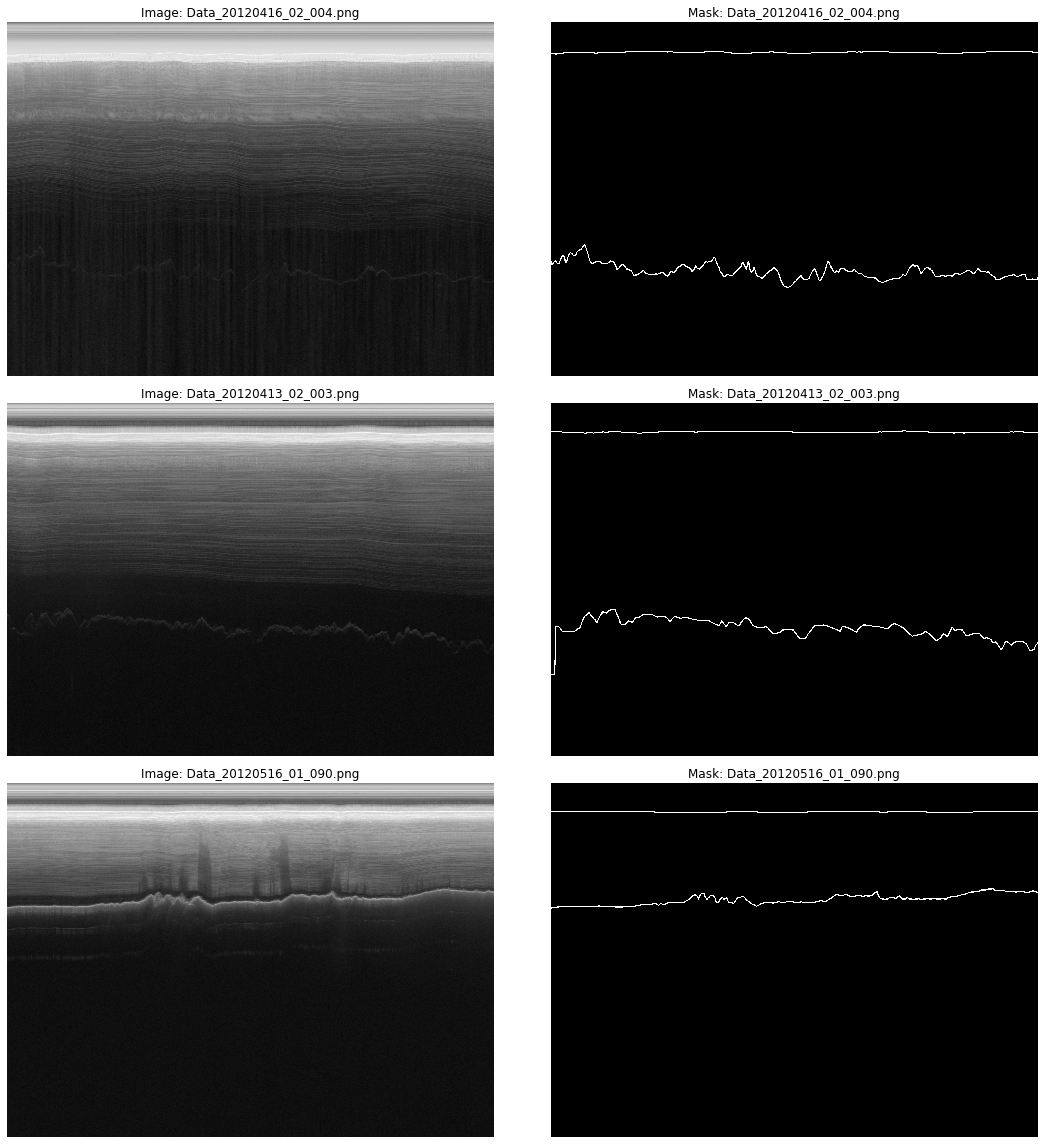

In [168]:

image_folder = "./LAYERS-images_one_channel" 
mask_folder = "./Surface_bedrock_3"

# Get all image filenames
all_images = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# Randomly select 5 images
selected_images = random.sample(all_images, 3)

# Plot the selected images and their corresponding masks
fig, axes = plt.subplots(3, 2, figsize=(16 ,16))  

for i, image_name in enumerate(selected_images):
    # Read image and its corresponding mask
    image_path = os.path.join(image_folder, image_name)
    mask_path = os.path.join(mask_folder, image_name)
    
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)
    
    # Plot image and mask
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f"Image: {image_name}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f"Mask: {image_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# DeeplabV3Plus with data generator
output_file = "Deeplabv3_1.txt"
input_dir = "/home/in18657@ad.umbc.edu/Surface/LAYERS-images_one_channel"  
target_dir = "/home/in18657@ad.umbc.edu/Surface/Surface_bedrock_3"
def on_epoch_end(epoch, logs):
    message = (f'Epoch: {epoch+1}\n'
               f'Train loss: {logs["loss"]}\n'
               f'Train binary IOU: {logs["binary_iou"]}\n'
               f'Train dice coef: {logs["dice_coef"]}\n'
               f'Train F1: {logs["F1_score"]}\n'
               f'------------------------\n'
               f'Val loss: {logs["val_loss"]}\n'
               f'Val binary IOU: {logs["val_binary_iou"]}\n'
               f'Val dice coef: {logs["val_dice_coef"]}\n'
               f'Val F1: {logs["val_F1_score"]}\n'
               f'------------------------\n')
 
    save_to_file(message)

epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end)
def save_to_file(message):
    with open(output_file, "a") as file:
        file.write(message + "\n")

# Optional: clear the results file at the start of each run
with open(output_file, "w") as file:
    file.write("")
message = "Current Time = " + datetime.datetime.now().strftime("%H:%M:%S")
print(message)
save_to_file(message)

input_img_paths, target_img_paths = read_files(input_dir, target_dir)
train_img_paths, test_img_paths, train_mask_paths, test_mask_paths = train_test_split(input_img_paths, target_img_paths, test_size=0.2, random_state=42)
import random
num_folds = 5
batch_size = 12
history_list = []
epochs = 300

kf = KFold(n_splits=num_folds, shuffle=False)
combined = list(zip(input_img_paths, target_img_paths))
random.shuffle(combined)
input_img_paths[:], target_img_paths[:] = zip(*combined)
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(train_img_paths)):  # Notice the change here
    message = f'Fold {fold + 1}'
    print(message)
    save_to_file(message)


    # Split the data into train and validation sets for this fold
    train_images, val_images = np.array(train_img_paths)[train_index], np.array(train_img_paths)[val_index]  # Convert list to np.array
    train_masks, val_masks = np.array(train_mask_paths)[train_index], np.array(train_mask_paths)[val_index]  # Convert list to np.array


    img_dims = (512,512,3)
    mask_dims = (512,512,1)

    train_generator = DataGenerator(train_images, train_masks, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    
    val_generator = DataGenerator(val_images, val_masks, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    test_generator = DataGenerator(test_img_paths, test_mask_paths, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    #print(train_images.shape)
    #print(train_masks.shape)
    with strategy.scope():
        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,  # Reduced initial learning rate
    decay_steps=5000,            # More frequent decay
    decay_rate=0.95              # Slower decay rate
)
        
        model = DeeplabV3Plus(image_size=IMAGE_SIZE)
  
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=0, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_model_deeplab_fold_{fold}.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=epochs,
                        callbacks=[early_stop, checkpoint, epoch_end_callback],
                        verbose=1)

    save_model(model, f'complete_model_deeplab_fold_{fold}.h5')
    history_list.append(history.history)
    model.load_weights(f'best_model_deeplab_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_generator)
    val_scores = model.evaluate(val_generator)
    test_scores = model.evaluate(test_generator)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    message = (f'Fold {fold+1}\n'
          f'Train loss: {train_scores[0]}\n'
          f'Train binary IOU: {train_scores[1]}\n'
          f'Train dice coef: {train_scores[2]}\n'
          f'Train F1: {train_scores[3]}\n'
          f'------------------------\n'
          f'Val loss: {val_scores[0]}\n'
          f'Val binary IOU: {val_scores[1]}\n'
          f'Val dice coef: {val_scores[2]}\n'
          f'Val F1: {val_scores[3]}\n'
          f'------------------------\n'
          f'test loss: {test_scores[0]}\n'
          f'test binary IOU: {test_scores[1]}\n'
          f'test_dice coef: {test_scores[2]}\n'
          f'test F1: {test_scores[3]}\n'
          f'------------------------')
    print(message)
    save_to_file(message)


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
std_test_loss = np.std(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
std_test_binary_iou = np.std(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
std_test_dice_coef = np.std(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)
std_test_f1 = np.std(test_f1_scores)
message = (f'------------------------\n'
          f'Average train loss: {avg_train_loss}\n'
          f'Average train binary IoU: {avg_train_binary_iou}\n'
          f'Average train Dice coefficient: {avg_train_dice_coef}\n'
          f'Average train F1 score: {avg_train_f1}\n'
          f'------------------------\n'
          f'Average validation loss: {avg_val_loss}\n'
          f'Average validation binary IoU: {avg_val_binary_iou}\n'
          f'Average validation Dice coefficient: {avg_val_dice_coef}\n'
          f'Average validation F1 score: {avg_val_f1}\n'
          f'------------------------\n'
          f'Average test loss: {avg_test_loss}\n'
          f'Average test binary IoU: {avg_test_binary_iou}\n'
          f'Average test Dice coefficient: {avg_test_dice_coef}\n'
          f'Average test F1 score: {avg_test_f1}\n'
          f'------------------------\n'
          f'Current Time: {datetime.datetime.now().strftime("%H:%M:%S")}')
print(message)
save_to_file(message)
# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('Average validation F1 score:', avg_val_f1)

print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print('------------------------')

print('std test loss:', std_test_loss)
print('std test binary IoU:', std_test_binary_iou)
print('std test Dice coefficient:', std_test_dice_coef)
print('std test F1 score:', std_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

A sample of running a model

U-Net

In [127]:
# U-Net with data augmentation
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []
IMAGE_DIMS=(512,512,3)

from sklearn.model_selection import KFold

kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(image)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = image[train_index], image[val_index]
    train_masks, val_masks = mask[train_index], mask[val_index]
    with strategy.scope():
        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)  
        model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")

        model.compile(optimizer=tf.keras.optimizers.Adam(),
        loss=dice_loss,
       metrics=[binary_iou,dice_coef,F1_score])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=0, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_model_U_Net_aug_noise_flip_fold_{fold}.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    history = model.fit(train_images, train_masks, epochs=300, batch_size=12, validation_data=(val_images, val_masks), callbacks=[early_stop, checkpoint], verbose=1)
    predictions = model.predict(train_images[:5])  # Inspect the first few predictions
    save_model(model, f'complete_model_U_Net_aug_noise_flip_fold_{fold}.h5')
    history_list.append(history.history)
    model.load_weights(f'best_model_U_Net_aug_noise_flip_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)

std_train_loss = np.std(train_loss_scores)
std_train_binary_iou = np.std(train_binary_iou_scores)
std_train_dice_coef = np.std(train_dice_coef_scores)
std_train_f1 = np.std(train_f1_scores)


print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
std_val_loss = np.std(val_loss_scores)
std_val_binary_iou = np.std(val_binary_iou_scores)
std_val_dice_coef = np.std(val_dice_coef_scores)
std_val_f1 = np.std(val_f1_scores)


print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

std_test_loss = np.std(test_loss_scores)
std_test_binary_iou = np.std(test_binary_iou_scores)
std_test_dice_coef = np.std(test_dice_coef_scores)
std_test_f1 = np.std(test_f1_scores)


# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('Average validation F1 score:', avg_val_f1)

print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print('------------------------')


print('std train loss:', std_train_loss)
print('std train binary IoU:', std_train_binary_iou)
print('std train Dice coefficient:', std_train_dice_coef)
print('std train F1 score:', std_train_f1)
print('------------------------')
print('std val loss:', std_val_loss)
print('std val binary IoU:', std_val_binary_iou)
print('std val Dice coefficient:', std_val_dice_coef)
print('std val F1 score:', std_val_f1)
print('------------------------')
print('std test loss:', std_test_loss)
print('std test binary IoU:', std_test_binary_iou)
print('std test Dice coefficient:', std_test_dice_coef)
print('std test F1 score:', std_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 16:42:57
Fold 0
Epoch 1/300
68/68 [==============================] - ETA: 0s - loss: 0.9050 - binary_iou: 0.5047 - dice_coef: 0.0950 - F1_score: 0.2609
Epoch 1: val_loss improved from inf to 0.97840, saving model to best_model_U_Net_aug_noise_flip_fold_0.h5
68/68 [==============================] - 31s 194ms/step - loss: 0.9050 - binary_iou: 0.5047 - dice_coef: 0.0950 - F1_score: 0.2609 - val_loss: 0.9784 - val_binary_iou: 0.4902 - val_dice_coef: 0.0216 - val_F1_score: 3.0186e-04
Epoch 2/300
68/68 [==============================] - ETA: 0s - loss: 0.7725 - binary_iou: 0.6735 - dice_coef: 0.2275 - F1_score: 0.5442
Epoch 2: val_loss improved from 0.97840 to 0.95673, saving model to best_model_U_Net_aug_noise_flip_fold_0.h5
68/68 [==============================] - 9s 126ms/step - loss: 0.7725 - binary_iou: 0.6735 - dice_coef: 0.2275 - F1_score: 0.5442 - val_loss: 0.9567 - val_binary_iou: 0.5142 - val_dice_coef: 0.0433 - val_F1_score: 0.0686
Epoch 3/300
68/68 [===============

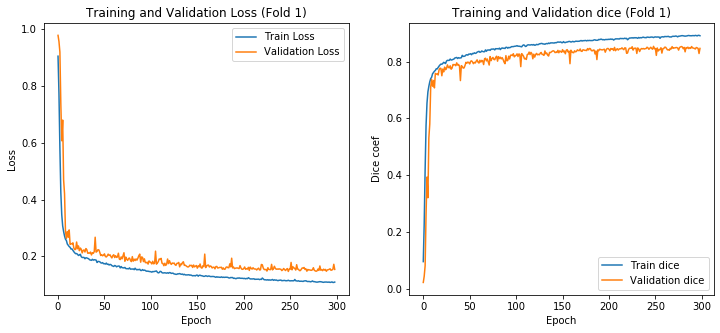

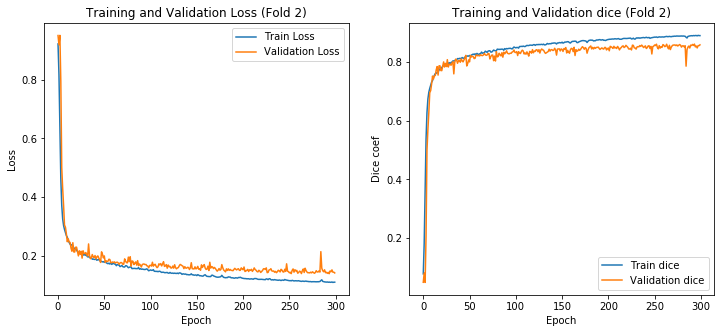

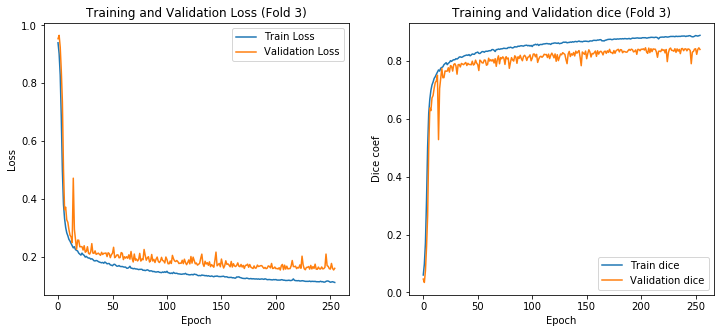

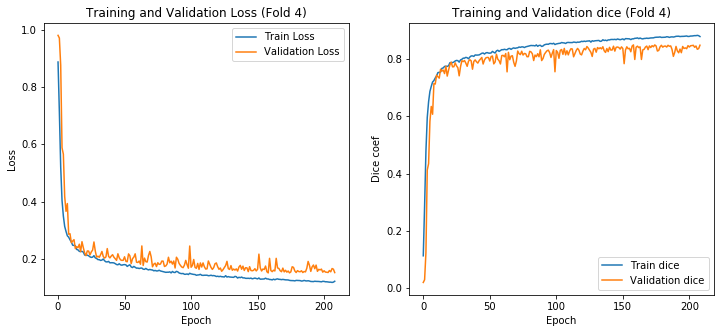

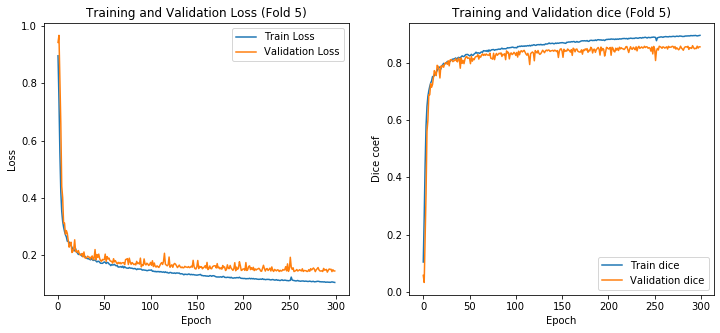

255/255 [==============================] - 2s 9ms/step


In [128]:
plot_history(history_list, 5)
model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")
model.load_weights('best_model_U_Net_aug_noise_flip_fold_0.h5')

train_folder_path = './Prediction/train_U_Net_aug_noise_flip'
test_folder_path = './Prediction/Prediction/test_U_Net_aug_noise_flip'


save_model_results(model, image, mask, X_test, y_test, train_folder_path, test_folder_path)